In [204]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

import mlflow
from mlflow.models import infer_signature

from sklearn.model_selection import train_test_split

In [205]:
df = pandas.read_csv("data/taxi_fare_train.csv")
display(df)

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,105.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,142.200,0
2,730.0,3.12,1.0,71.25,0,26.625,97.875,1
3,671.0,5.63,3.0,90.00,0,9.750,99.750,0
4,329.0,2.09,1.0,45.00,12,13.200,70.200,0
...,...,...,...,...,...,...,...,...
49993,836.0,2.95,1.0,78.75,21,26.700,126.450,1
49994,357.0,2.66,1.0,52.50,0,34.125,86.625,1
49995,1941.0,9.19,1.0,183.75,0,26.625,210.375,1
49996,438.0,1.75,1.0,48.75,8,5.500,62.250,0


In [232]:

inputs = np.array(df[['trip_duration', 'distance_traveled']].values.tolist(), dtype=np.float32)
# inputs = np.array(df['distance_traveled'].values.tolist(), dtype=np.float32)
targets = np.array(df['fare'].values.tolist(), dtype=np.float32)

In [252]:
X = torch.from_numpy(inputs).type(torch.float32).unsqueeze(dim=1)
y = torch.from_numpy(targets).type(torch.float32).unsqueeze(dim=1)
X.shape


torch.Size([49998, 1, 2])

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [247]:
n_samples  = X.shape[0]
n_features = X.shape[1]
output_size = 1

In [243]:
def plot_prediction(train_data = X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, prediction = None):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data,train_labels,c='b',s=4,label="Training Data")
    plt.scatter(test_data,test_labels,c="y",s=4,label="Testing Data")

    if prediction is not None:
        plt.scatter(test_data, prediction,c="r",s=4,label="Prediction")

    plt.legend(prop={"size":14})

ValueError: x and y must be the same size

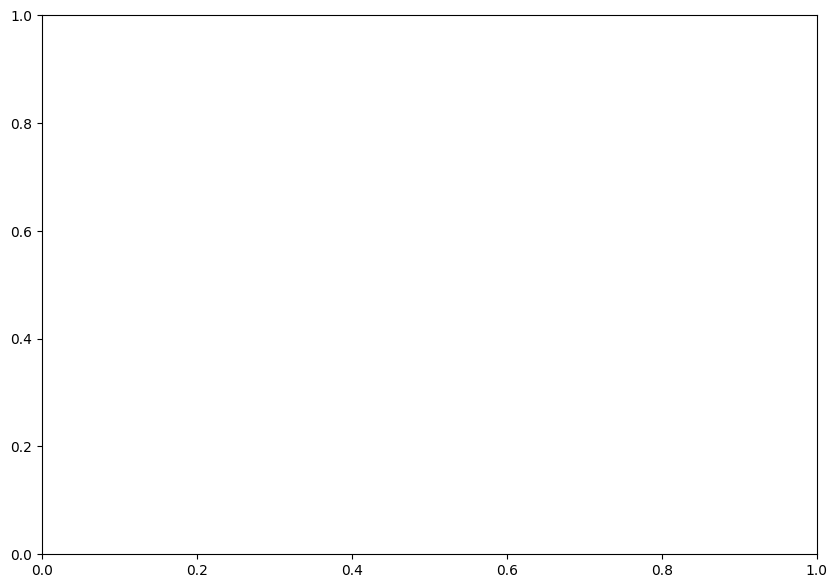

In [244]:
plot_prediction()

In [248]:
class LinearRegrassionModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.linear_layer = nn.Linear(in_features=n_features, out_features=output_size)

    def forward(self, x:torch.Tensor)-> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(0)
model_1 = LinearRegrassionModel()
model_1, model_1.state_dict()

(LinearRegrassionModel(
   (linear_layer): Linear(in_features=2, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.0053,  0.3793]])),
              ('linear_layer.bias', tensor([-0.5820]))]))

In [249]:
with torch.inference_mode():
    y_predict = model_1(X_test)

plot_prediction(prediction=y_predict)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (20000x1 and 2x1)

In [250]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [251]:
torch.manual_seed(0)
epochs = 3000
best_loss = 200
for epoch in range(epochs):

    model_1.train()

    y_predict = model_1(X_train)

    loss = loss_fn(y_predict, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
        test_predict = model_1(X_test)
        test_loss = loss_fn(test_predict, y_test)

    if (epoch+1)%100 == 0:
        print(f'Epoch {epoch+1} | Training Loss : {loss} | Testing loss : {test_loss}')
        
    
    if test_loss < best_loss:
        torch.save(model_1, f'run/best_taxi_fare_model.pt')
        best_loss = test_loss



RuntimeError: mat1 and mat2 shapes cannot be multiplied (79996x1 and 2x1)

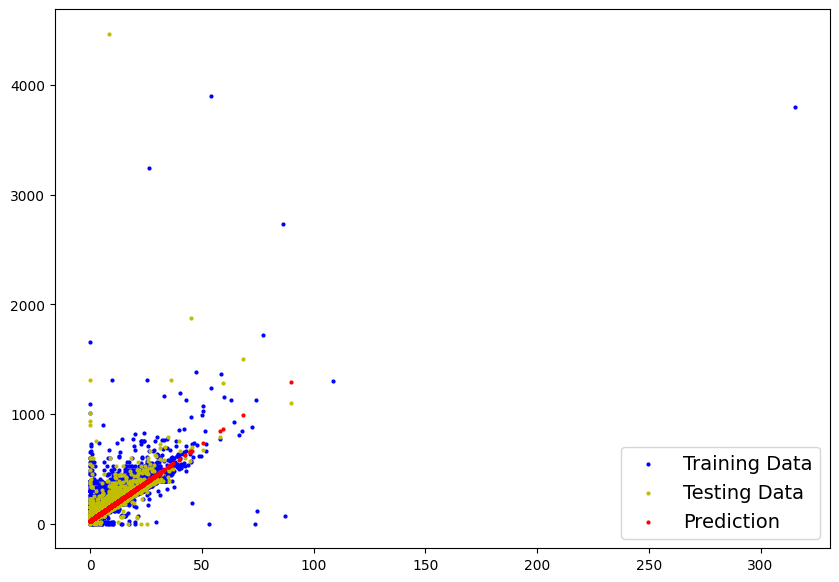

In [216]:
with torch.inference_mode():
    y_predict = model_1(X_test)

plot_prediction(prediction=y_predict)

In [227]:
model_test = torch.load('run/best_taxi_fare_model.pt')
model_test.eval()
test_num = torch.Tensor([[2.5]]).type(torch.float32)
with torch.inference_mode():
    pred = model_test(test_num)

pred = pred.detach().cpu().numpy()
print(pred[0])

[61.366943]


In [231]:
version = 2
test_num = torch.Tensor([[2.5]]).type(torch.float32)
mlflow.set_experiment(experiment_name="taxi_fare_model")
mlflow.end_run()
with mlflow.start_run() as run:
    mlflow.set_tag("mlflow.runName", f"version_{version}")
    signature = infer_signature(X.numpy(), model_test(X_test).detach().numpy())
    model_info = mlflow.pytorch.log_model(model_test, "model_1", signature=signature)

# pytorch_pyfunc = mlflow.pyfunc.load_model(model_uri=model_info.model_uri)
# predictions = pytorch_pyfunc.predict(test_num)
# print(predictions)